# Generate data for the analysis

In [5]:
import numpy as np
import meshio

def input_data():
    """
    This function defines input parameters for the Boundary Element Method (BEM)
    simulation applied to the plane elasticity equation with radial integration for domain
    integrals.

    Returns:
        dict: A dictionary containing the following key-value pairs:
            * bound_cond (dict): Boundary conditions for each edge:
                *
            * E (float): Material elastic modulus
            * nu (float): Poisson's ratio
            * file_name (str): Name of the .msh file (Gmsh mesh)
            * qpoint (str): String representing the coordinates of the heat source point
    """
    # Directly define values here for scripting (modify as needed)
    # Boundary conditions are specified in local coordinate system (normal-tangent)
    # type_n = type of the boundary condition in normal direction
    # type_t = type of the boundary condition in tangent direction
    #    (type_n and type_t: 0 = displacement is know 1 = traction is known)
    bound_cond = {'fixed': {'type_n': 0, 'value_n': 0, 'type_t': 0, 'value_t': 0},
        'free': {'type_n': 1, 'value_n': 0, 'type_t': 1, 'value_t': 0},
        'loaded': {'type_n': 1, 'value_n': 1., 'type_t': 1, 'value_t': 0}
    }
    E = 1.0
    nu = 0.3
    file_name = '../gmsh/plate'
    qpoint = '0.'  # Heat source

    return {'bound_cond': bound_cond, 'E': E, 'nu': nu, 'file_name': file_name,
            'qpoint': qpoint}

In [6]:
# Read information about input data
inp_data = input_data()

In [9]:
def compute_inodes(file_name, bound_cond):
    """
    This function reads a mesh file and extracts information about nodes, elements,
    and boundary conditions.

    Args:
      file_name: Name of the mesh file.
      bound_cond: Dictionary containing boundary conditions for each edge.

    Returns:
      A dictionary containing information about nodes, elements, and boundary
      conditions.
    """
    mesh = meshio.read(file_name + '.msh')
    coordinates = mesh.points
    line_elements = mesh.cells_dict['line']
    triangle_elements = mesh.cells_dict['triangle']
    segments = mesh.cell_data_dict['gmsh:physical']['line']

    bc_info = {}
    for key, value in bound_cond.items():
        segment = mesh.field_data[key][0]
        bc_info[key] = {
            'type_n': value['type_n'],
            'value_n': value['value_n'],
            'segment': segment,
            'type_t': value['type_t'],
            'value_t': value['value_t']
        }

    boundary_nodes = np.unique(line_elements)
    all_nodes = np.unique(triangle_elements)
    internal_nodes = [node for node in all_nodes if node not in boundary_nodes]

    return {
        'boundary_nodes': boundary_nodes,
        'internal_nodes': internal_nodes,
        'all_nodes': all_nodes,
        'coordinates': coordinates,
        'line_elements': line_elements,
        'triangle_elements': triangle_elements,
        'segments': segments,
        'bc_info': bc_info
    }


In [10]:
# Format input data
computed_data = compute_inodes(inp_data['file_name'], inp_data['bound_cond'])

In [11]:
def mount_bcs(segments, bc_info):
    """
    Constructs a boundary condition matrix from segment information and boundary condition data.

    This function takes a list of segment indices (`segments`) and a dictionary of boundary condition
    information (`bc_info`) to create a matrix (`bcs`) that stores the type and value of the boundary
    condition for each element.

    Args:
        segments (list or np.ndarray): A list or array of integers representing the indices of the boundary
                                       elements (segments) in the problem.
        bc_info (dict): A dictionary containing boundary condition information. The keys are typically
                        strings representing boundary condition names, and the values are dictionaries
                        with the following structure:
                        {
                            'type_n': bc_type,     # The type of boundary condition in n (0 for Dirichlet, 1 for Neumann)
                            'value_n': bc_value    # The value of the boundary condition in n (displacement or traction)
                            'segment': segment_index,  # The index of the segment this BC applies to
                            'type': bc_type,          # The type of boundary condition in t (0 for Dirichlet, 1 for Neumann)
                            'value': bc_value         # The value of the boundary condition in t (displacement or traction)
                        }

    Returns:
        bcs (np.ndarray): A 2D NumPy array where each row corresponds to a boundary element. The first
                         and third column contains the boundary condition type (0 or 1), and the second
                         and fourth column contains the boundary condition value.
    """

    num_elements = len(segments)

    # Initialize boundary condition matrix
    bcs = np.zeros((2*num_elements, 4), dtype=np.float64)

    # Populate boundary condition matrix (bcs)
    for i, segment_index in enumerate(segments):
        # Find the boundary condition data corresponding to the current segment
        for bc_name, bc_data in bc_info.items():
            if bc_data['segment'] == segment_index:
                tp_n=bc_data['type_n']
                vl_n= bc_data['value_n']
                tp_t=bc_data['type_t']
                vl_t= bc_data['value_t']
                bcs[2*i:2*i+2, 0] = np.array([tp_n,tp_n])  # Store boundary condition type
                bcs[2*i:2*i+2, 1] = np.array([vl_n,vl_n]) # Store boundary condition value
                bcs[2*i:2*i+2, 2] = np.array([tp_t,tp_t])  # Store boundary condition type
                bcs[2*i:2*i+2, 3] = np.array([vl_t,vl_t]) # Store boundary condition value
                break  # Move on to the next segment once the BC is found
    return bcs



def comp_node_and_normal(elem, nodes):
    """
    Calculates the midpoint and outward normal vector for each boundary element.

    This function takes element connectivity information (`elem`) and node coordinates (`nodes`)
    to determine the geometric center of each boundary element and the unit normal vector
    pointing outward from that element.

    Args:
        elem (np.ndarray): A 2D array defining the connectivity of the boundary elements.
                          Each row contains the indices of the two nodes that form an element.
                          Shape: (num_elements, 2).
        nodes (np.ndarray): A 2D array containing the coordinates (x, y) of each node in the mesh.
                           Shape: (num_nodes, 2).

    Returns:
        node_des (np.ndarray): A 2D array containing the coordinates (x, y) of the discontinuous nodes
                              of each boundary element. Shape: (2*num_elements, 2).
        normal (np.ndarray): A 2D array containing the unit outward normal vectors for each
                             boundary element. Shape: (num_elements, 2).
    """

    num_elements = elem.shape[0]

    # Initialize arrays to store results
    node_des = np.zeros((2*num_elements, 2))  # Midpoint coordinates
    normal = np.zeros((2*num_elements, 2))    # Outward normal vectors

    # Iterate over each boundary element
    for i in range(num_elements):
        # Get node indices for the current element
        node1, node2 = elem[i]

        # Get coordinates of the two nodes forming the element
        x1, y1 = nodes[node1][0:2]
        x2, y2 = nodes[node2][0:2]


        # Calculate the midpoint coordinates
        node_des[2*i,:] = [x1+(x2 - x1) / 4, y1+(y2 - y1) / 4]

        # Calculate the midpoint coordinates
        node_des[2*i+1,:] = [x1+3*(x2 - x1) / 4, y1+3*(y2 - y1) / 4]

        # Calculate the length of the element
        L = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

        # Calculate the unit tangent vector (from node1 to node2)
        tangent_x = (x2 - x1) / L
        tangent_y = (y2 - y1) / L

        # Calculate the outward unit normal vector (rotate tangent 90 degrees counterclockwise)
        normal[2*i,:] = [tangent_y, -tangent_x]
        normal[2*i+1,:] = [tangent_y, -tangent_x]

    return node_des, normal

In [12]:
# Compute the mid point of the elements and normal vector at this mid point
nodes, normal = comp_node_and_normal(computed_data['line_elements'], computed_data['coordinates'])

# Generate bcs array with boundary conditions in each element
bcs = mount_bcs(computed_data['segments'], computed_data['bc_info'])

# Show mesh and geometry

In [13]:
def show_problem(nodes, normal, coord, bcs, tri):
    """
   Visualizes the mesh and boundary conditions of a 2D problem.

    This function generates a plot that displays:

    - Mesh: The underlying triangular mesh structure used for the problem.
    - Known Displacement Nodes: Nodes where the displacement is prescribed
       (Dirichlet boundary conditions). Marked as red dots.
    - Known Traction Nodes: Nodes where the traction is prescribed (Neumann boundary
       conditions). Marked as blue dots.
    - Normal Vectors: Arrows indicating the direction of the outward normal
       vectors at nodes with known traction (blue arrows) or displacement (red arrows).
       The length of the arrow is scaled by the magnitude of the displacement/traction.

    Args:
        node_med (np.ndarray): A 2D array containing the coordinates of the midpoint
                              of each element in the mesh. Shape: (num_elements, 2).
        normal (np.ndarray): A 2D array containing the outward normal vectors at
                             each element midpoint. Shape: (num_elements, 2).
        coord (np.ndarray): A 2D array containing the coordinates of all nodes in
                            the mesh. Shape: (num_nodes, 2).
        bcs (np.ndarray): A 2D array containing the boundary condition information
                          for each element. Each row has the following structure:
                          [element_index, bc_type n, bc_value n, bc_type t, bc_value t].
                          - bc_type: 0 for Dirichlet (known displacement), 1 for
                                     Neumann (known traction).
                          - bc_value: The prescribed displacement or traction value.
        tri (np.ndarray): A 2D array defining the connectivity of the mesh
                          (element-node relationships). Each row contains the
                          indices of the three nodes forming a triangle.
                          Shape: (num_triangles, 3).
    """

    # Extract indices of elements with known displacement and traction conditions
    indknown_ux = np.where(bcs[:, 0] == 0)[0]  # Dirichlet BC (known displacement)
    indknown_tx = np.where(bcs[:, 0] == 1)[0]  # Neumann BC (known traction)
    indknown_uy = np.where(bcs[:, 2] == 0)[0]  # Dirichlet BC (known displacement)
    indknown_ty = np.where(bcs[:, 2] == 1)[0]  # Neumann BC (known traction)

    # Determine plot limits to provide a 15% margin around the geometry
    x_min, x_max = np.min(coord[:, 0]), np.max(coord[:, 0])
    y_min, y_max = np.min(coord[:, 1]), np.max(coord[:, 1])
    delta_x, delta_y = x_max - x_min, y_max - y_min

    # Get the current axes for plotting
    ax = plt.gca()
    plt.grid(True)  # Turn on gridlines for better visualization

    # Plot the triangular mesh
    plt.triplot(coord[:, 0], coord[:, 1], tri, color="black", linewidth=0.4)

    # Plot normal vectors (scaled by BC value) for elements with known traction (blue)
    plt.quiver(nodes[indknown_tx, 0], nodes[indknown_tx, 1],
               normal[indknown_tx, 0] * bcs[indknown_tx, 1], normal[indknown_tx, 1] * bcs[indknown_tx, 1],
               color="blue", angles='xy', scale_units='xy', scale=10, width=0.004, headaxislength=0)

    # Plot normal vectors (scaled by BC value) for elements with known displacement (red)
    plt.quiver(nodes[indknown_ux, 0], nodes[indknown_ux, 1],
               normal[indknown_ux, 0] * bcs[indknown_ux, 1], normal[indknown_ux, 1] * bcs[indknown_ux, 1],
               color="red", angles='xy', scale_units='xy', scale=10, width=0.004, headaxislength=0)

  # Plot normal vectors (scaled by BC value) for elements with known traction (blue)
    plt.quiver(nodes[indknown_ty, 0], nodes[indknown_ty, 1],
               -normal[indknown_ty, 1] * bcs[indknown_ty, 3], normal[indknown_ty, 0] * bcs[indknown_ty, 3],
               color="blue", angles='xy', scale_units='xy', scale=10, width=0.004, headaxislength=0)

    # Plot normal vectors (scaled by BC value) for elements with known displacement (red)
    plt.quiver(nodes[indknown_uy, 0], nodes[indknown_uy, 1],
               -normal[indknown_uy, 1] * bcs[indknown_uy, 3], normal[indknown_uy, 0] * bcs[indknown_uy, 3],
               color="red", angles='xy', scale_units='xy', scale=10, width=0.004, headaxislength=0)


    # Plot nodes with known displacement (red dots)
    plt.plot(nodes[indknown_ux, 0], nodes[indknown_ux, 1], 'rx', markersize=6)

    # Plot nodes with known traction (blue dots)
    plt.plot(nodes[indknown_tx, 0], nodes[indknown_tx, 1], 'bx', markersize=6)

    # Plot nodes with known displacement (red dots)
    plt.plot(nodes[indknown_uy, 0], nodes[indknown_uy, 1], 'rP', markersize=4)

    # Plot nodes with known traction (blue dots)
    plt.plot(nodes[indknown_ty, 0], nodes[indknown_ty, 1], 'bP', markersize=4)

    # Set plot aspect ratio and adjust limits for a better visual representation
    plt.axis("equal")
    ax.set_xlim(x_min - 0.15 * delta_x, x_max + 0.15 * delta_x)
    ax.set_ylim(y_min - 0.15 * delta_y, y_max + 0.15 * delta_y)

    # Show the plot
    plt.show()

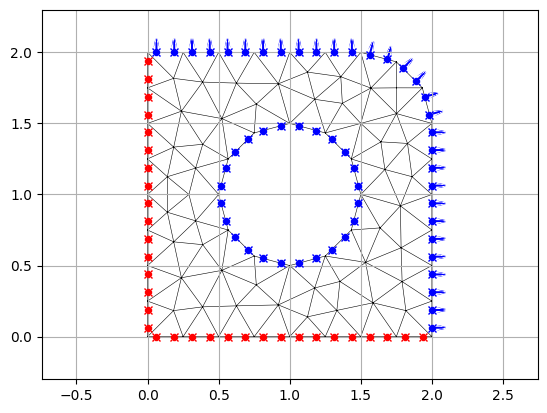

In [14]:
# Show geometry and boundary conditions
import matplotlib.pyplot as plt
nodes_coord = computed_data['coordinates']
show_problem(nodes,normal,nodes_coord,bcs,computed_data['triangle_elements'])

# Displacement fundamental solution for plane elasticity

$$ u_{i k}^*=\frac{1}{8 \pi \mu(1-v)}\left[(3-4 v) \ln \frac{1}{r} \delta_{i k}+r_{,i} r_{, k}\right]$$


where

$$\mu=\frac{E}{2(1+\nu)}$$

Term 11 of the fundamental solution can be written as:


$$u^*_{11}=\frac{1}{8 \pi \mu(1-v)}\left[(3-4 v) \ln \frac{1}{r} + r_{, 1}^2\right] =\frac{(3-4 v) \ln \frac{1}{r} + r_{, 1}^2}{8 \pi \mu(1-v)}$$

Calling

$$c_1 = 4 \pi (1-\nu)$$
$$c_2 = (3-4\nu)\log\frac{1}{r}$$

we can write:

$$u^*_{11} = \frac{c_2 + r_{,1}^2}{2c_1 \mu}$$

In the same way, we have:

$$u^*_{22} = \frac{c_2 + r_{,2}^2}{2c_1\mu}$$

$$u^*_{12} = \frac{r_{,1}r_{,2}}{2c_1\mu}$$

$$u^*_{21}=u^*_{12}$$

# Traction fundamental solution for plane elasticity

$$ t_{i k}^*=-\frac{1}{4 \pi(1-v) r}\left[\frac{\partial r}{\partial n}\left[(1-2 v) \delta_{i k}+2 r_{,} r_{. k}\right]+(1-2 v)\left(n_l r_{, k}-n_k r_{, l}\right]\right] $$

Calling

$$c_3 = r_{,1}n_1 + r_{,2}n_2$$

we have

$$ t^*_{11} = -\left\{\frac{c_3[(1-2\nu)+2r_{,1}^2]}{c_1r}\right\}$$
$$ t^*_{22} = -\left\{\frac{c_3[(1-2\nu)+2r_{,2}^2]}{c_1r}\right\} $$
$$ t^*_{12} = -\left[\frac{2c_3 r_{,1} r_{,2}-(1-2\nu)(r_{,1}n_2-r_{,2}n_1)}{c_1r}\right]$$
$$t^*_{21} = -\left[\frac{2c_3r_{,1}r_{,2}-(1-2\nu)(r_{,2}n_1-r_{,1}n_2)}{c_1r}\right]$$



In [15]:
def compute_fund_solution(r1, r2, r, nx, ny, E, nu):
  """
  Computes the fundamental solution for plane elasticity.

  Args:
    r1: x-coordinate of the distance vector.
    r2: y-coordinate of the distance vector.
    r: Magnitude of the distance vector.
    nx: x-component of the outward normal vector.
    ny: y-component of the outward normal vector.
    E: Young's modulus.
    nu: Poisson's ratio.

  Returns:
    A tuple containing the displacement and traction fundamental solution matrices.
  """
  mu = E / (2 * (1 + nu))
  # Components of the unity vector in the radial direction
  rd1 = r1 / r
  rd2 = r2 / r
  # Plane elasticity fundamental solutions
  c1 = 4 * np.pi * (1 - nu)
  c2 = (3 - 4 * nu) * np.log(1 / r)
  c3 = rd1 * nx + rd2 * ny

  u11 = (c2 + rd1 ** 2) / (2 * c1 * mu)
  u22 = (c2 + rd2 ** 2) / (2 * c1 * mu)
  u12 = (rd1 * rd2) / (2 * c1 * mu)
  u21 = u12

  t11 = -(c3 * ((1 - 2 * nu) + 2 * rd1 ** 2)) / (c1 * r)
  t22 = -(c3 * ((1 - 2 * nu) + 2 * rd2 ** 2)) / (c1 * r)
  t12 = -((c3 * 2 * rd1 * rd2) - (1 - 2 * nu) * (rd1 * ny - rd2 * nx)) / (c1 * r)
  t21 = -((c3 * 2 * rd1 * rd2) - (1 - 2 * nu) * (rd2 * nx - rd1 * ny)) / (c1 * r)

  # Assembly of matrices that contain fundamental solutions
  uast = np.array([[u11, u12], [u21, u22]])
  tast = np.array([[t11, t12], [t21, t22]])
  return uast, tast


# Analytical integration of matrix ${\bf G}$ when the source point belongs to the element


$${\bf G_{\rm el}} = \int_{-1}^1\left[\begin{array}{cc}u^*_{11}& u^*_{12}\\u^*_{21}& u^*_{22}\end{array}\right]\left[\begin{array}{cccc}N_{1} & 0 &N_{2}& 0\\0& N_{1} & 0 &N_{2}\end{array}\right]\frac{L}{2}d\xi = \left[\begin{array}{cccc}\int_{-1}^1u^*_{11}N_{1}\frac{L}{2}d\xi & \int_{-1}^1u^*_{12}N_{1}\frac{L}{2}d\xi &\int_{-1}^1u^*_{11}N_{2}\frac{L}{2}d\xi& \int_{-1}^1u^*_{12}N_{2}\frac{L}{2}d\xi\\\int_{-1}^1u^*_{21}N_{1}\frac{L}{2}d\xi&\int_{-1}^1 u^*_{22}N_{1}\frac{L}{2}d\xi & \int_{-1}^1u^*_{21}N_{2}\frac{L}{2}d\xi &\int_{-1}^1u^*_{22}N_{2}\frac{L}{2}d\xi\end{array}\right]= \left[\begin{array}{cccc}g_{11} & g_{12} &g_{13}& g_{14}\\g_{21}& g_{22}& g_{23}&g_{24}\end{array}\right]$$

$$ x = N_1 x_1 + N_2 x_2$$

$$ N_1 = -\xi + \frac{1}{2} $$

$$ N_2 = \xi + \frac{1}{2} $$

$$ x = \left( -\xi + \frac{1}{2}
 \right) x_1+\left( \xi + \frac{1}{2}
 \right) x_2$$

 $$ x = \left( x_2 - x_1
 \right) \xi+\frac{1}{2}\left( x_1 +
 x_2\right) $$

 In the same way:

 $$ y = \left( y_2 - y_1
 \right) \xi+\frac{1}{2}\left( y_1 +
 y_2\right) $$


 $$ x_d = \left( x_2 - x_1
 \right) \xi_d+\frac{1}{2}\left( x_1 +
 x_2\right) $$

and

 $$ y_d = \left( y_2 - y_1
 \right) \xi_d+\frac{1}{2}\left( y_1 +
 y_2\right) $$


 $$ x - x_d = \left( x_2 - x_1
 \right) (\xi-\xi_d) $$


 $$ y - y_d = \left( y_2 - y_1
 \right) (\xi-\xi_d) $$

 $$r=\sqrt{(x-x_d)^2+(y-y_d)^2}=(|\xi-\xi_d|\sqrt{(x_2-x_1)^2+(y_2-y_1)^2} = \frac{|\xi-\xi_d|L}{2} $$

 $$r_{,1}=\frac{x-x_d}{r}=\frac{2\left( x_2 - x_1
 \right) (\xi-\xi_d)}{|\xi-\xi_d|L} $$

 $$r_{,2}=\frac{y-y_d}{r}=\frac{2\left( y_2 - y_1
 \right) (\xi-\xi_d)}{|\xi-\xi_d|L} $$




* Integration of the singular part

$$g_{11}^{(s)} = \int_{-1}^1 \left(-\xi+\frac{1}{2}\right)\log r d\xi $$

$$g_{11}^{(ns)} = \int_{-1}^1 \left(-\xi+\frac{1}{2}\right) r_{,1}^2d\xi $$

 $$g_{11}^{(s)}= \int_{-1}^1 \left(-\xi+\frac{1}{2}\right)\left[\log|\xi-\xi_d|+\log \left(\frac{L}{2}\right)\right]  d\xi  $$


 $$g_{11}^{(s)}= \left\{\int_{-1}^1 \left(-\xi+\frac{1}{2}\right)\log|\xi-\xi_d|d\xi+\log \left(\frac{L}{2}\right)\int_{-1}^1\left(-\xi+\frac{1}{2}\right) d\xi\right\}  $$


 $$g_{11}^{(s)}= \left\{\int_{-1}^1 -\xi\log|\xi-\xi_d|d\xi +\frac{1}{2}\int_{-1}^1\log|\xi-\xi_d|d\xi+.        \log \left(\frac{L}{2}\right)\int_{-1}^1\left(-\xi+\frac{1}{2}\right) d\xi\right\}  $$

 $$g_{11}^{(s)}= -1.781167572309405+     \log \left(\frac{L}{2}\right)$$

 * Integration of the non-singular part
$$g_{11}^{(ns)}=\int_{-1}^1 \left(-\xi+\frac{1}{2}\right) r_{,1}^2d\xi  =\int_{-1}^1 \left(-\xi+\frac{1}{2}\right) \left(\frac{2\left( x_2 - x_1
 \right) (\xi-\xi_d)}{|\xi-\xi_d|L} \right)^2d\xi$$

 $$ g_{11}^{(ns)} = \frac{4\left( x_2 - x_1
 \right)^2}{L^2} \int_{-1}^1 \left(-\xi+\frac{1}{2}\right) d\xi =\frac{4\left( x_2 - x_1
 \right)^2}{L^2} $$


 * Other terms of the matrix



$$g_{12}=g_{21}=\int_{-1}^1 N_1 u^*_{12} \frac{L}{2}d\xi =\frac{L}{2}\int_{-1}^1 N_1  \frac{r_{,1}r_{,2}}{2c_1\mu} d\xi =  \frac{L}{4c_1\mu}\int_{-1}^1 N_1 \frac{2\left( x_2 - x_1
 \right) (\xi-\xi_d)}{|\xi-\xi_d|L} \frac{2\left( y_2 - y_1
 \right) (\xi-\xi_d)}{|\xi-\xi_d|L} d\xi $$

 $$g_{12}=g_{21}=\frac{\left( x_2 - x_1
 \right)\left( y_2 - y_1
 \right)}{c_1L\mu}\int_{-1}^1 N_1 \frac{}{}  d\xi =\frac{\left( x_2 - x_1
 \right)\left( y_2 - y_1
 \right)}{c_1L\mu}   $$



$$g_{14}=g_{23}=\int_{-1}^1 N_2 u^*_{12} \frac{L}{2}d\xi =\frac{\left( x_2 - x_1
 \right)\left( y_2 - y_1
 \right)}{c_1L\mu}\int_{-1}^1 N_2 \frac{}{}  d\xi =\frac{\left( x_2 - x_1
 \right)\left( y_2 - y_1
 \right)}{c_1L\mu}$$

$$g_{13}^{(s)}=\int_{-1}^1 N_2 \log r d\xi = 0.042791644191678246+   \log \left(\frac{L}{2}\right) $$

$$g_{13}^{(ns)}=g_{11}^{(ns)}$$

$$g_{22}^{(s)}=g_{11}^{(s)}$$

$$g_{22}^{(ns)}=\frac{4\left( y_2 - y_1
 \right)^2}{L^2}$$


In [17]:
from scipy.integrate import quad
import numpy as np

# Integration for the first shape function, when N = N1 = -xi + 0.5

def func1(xi):
  xid=-.5
  return -xi*np.log(np.abs(xi-xid))

def func2(xi):
  xid=-.5
  return np.log(np.abs(xi-xid))

def func3(xi):
  return -xi+.5

I1 = quad(func1, -0.5, 1)[0]+quad(func1, -1., -0.5)[0]
I2 = quad(func2, -0.5, 1)[0]+quad(func2, -1., -0.5)[0]
I3 = quad(func3, -1., 1)
print("I = ",I1+I2/2)
print("I3 = ",I3[0])

I =  -1.781167572309405
I3 =  1.0


In [18]:
# Integration for the second shape function, when N = N2 = xi + 0.5
def func1(xi):
  xid=-.5
  return xi*np.log(np.abs(xi-xid))

def func3(xi):
  return xi+.5

I1 = quad(func1, -0.5, 1)[0]+quad(func1, -1., -0.5)[0]
I3 = quad(func3, -1., 1)
print("I = ",I1+I2/2)
print("I3 = ",I3[0])

I =  0.042791644191678246
I3 =  1.0


# Analytical integration of matrix ${\bf H}$ when the source point belongs to the element



$$c_3 = r_{,1}n_1 + r_{,2}n_2$$

we have

$$ t^*_{11} = -\left\{\frac{c_3[(1-2\nu)+2r_{,1}^2]}{c_1r}\right\}$$
$$ t^*_{22} = -\left\{\frac{c_3[(1-2\nu)+2r_{,2}^2]}{c_1r}\right\} $$
$$ t^*_{12} = -\left[\frac{2c_3 r_{,1} r_{,2}-(1-2\nu)(r_{,1}n_2-r_{,2}n_1)}{c_1r}\right]$$
$$t^*_{21} = -\left[\frac{2c_3r_{,1}r_{,2}-(1-2\nu)(r_{,2}n_1-r_{,1}n_2)}{c_1r}\right]$$




$${\bf H_{\rm el}} = \int_{-1}^1\left[\begin{array}{cc}t^*_{11}& t^*_{12}\\t^*_{21}& t^*_{22}\end{array}\right]\left[\begin{array}{cccc}N_{1} & 0 &N_{2}& 0\\0& N_{1} & 0 &N_{2}\end{array}\right]\frac{L}{2}d\xi = \left[\begin{array}{cccc}\int_{-1}^1t^*_{11}N_{1}\frac{L}{2}d\xi & \int_{-1}^1t^*_{12}N_{1}\frac{L}{2}d\xi &\int_{-1}^1t^*_{11}N_{2}\frac{L}{2}d\xi& \int_{-1}^1t^*_{12}N_{2}\frac{L}{2}d\xi\\\int_{-1}^1t^*_{21}N_{1}\frac{L}{2}d\xi&\int_{-1}^1 t^*_{22}N_{1}\frac{L}{2}d\xi & \int_{-1}^1t^*_{21}N_{2}\frac{L}{2}d\xi &\int_{-1}^1t^*_{22}N_{2}\frac{L}{2}d\xi\end{array}\right]= \left[\begin{array}{cccc}h_{11} & h_{12} &h_{13}& h_{14}\\h_{21}& h_{22}& h_{23}&h_{24}\end{array}\right]$$


 ## Source point at node 1 ($\xi_d=-\frac{1}{2}$):

 $$ h_{11}=-\frac{1}{2}+\bar{h}_{11}$$
 $$ h_{22}=-\frac{1}{2}+\bar{h}_{22}$$

 $$\bar{h}_{11}=\int_\Gamma N_1 t_{11}^* d\Gamma = \int_{-1}^1 N_1(\xi) t_{11}^* \frac{d\Gamma}{d\xi}d\xi = -\int_{-1}^1 \left(-\xi+\frac{1}{2}\right)\left\{\frac{c_3[(1-2\nu)+2r_{,1}^2]}{c_1r}\right\}\frac{L}{2}d\xi  $$


When the source point belongs to the element, $c_3=0$ because ${\bf r}$ and ${\bf n}$ are orthogonal vectors.

$$\bar{h}_{11}= \bar{h}_{22} = {h}_{13} = {h}_{24} = 0 $$




 $${h}_{14}=\int_\Gamma N_2 t_{12}^* d\Gamma = \int_{-1}^1 N_2(\xi) t_{11}^* \frac{d\Gamma}{d\xi}d\xi = \int_{-1}^1 N_2(\xi)\left\{-\left[\frac{2c_3 r_{,1} r_{,2}-(1-2\nu)(r_{,1}n_2-r_{,2}n_1)}{c_1r}\right]\right\}\frac{L}{2}d\xi $$

 $${h}_{14} =  \frac{L(1-2\nu)}{2c_1} \int_{-1}^1 N_2(\xi)\left[\frac{\frac{2\left( x_2 - x_1
 \right) (\xi-\xi_d)}{|\xi-\xi_d|L}n_2-\frac{2\left( y_2 - y_1
 \right) (\xi-\xi_d)}{|\xi-\xi_d|L}n_1}{\frac{|\xi-\xi_d|L}{2}}\right]d\xi $$


 $${h}_{14}=  \frac{2(1-2\nu)}{Lc_1} \int_{-1}^1 N_2(\xi)\left[\frac{\frac{\left( x_2 - x_1
 \right) (\xi-\xi_d)}{|\xi-\xi_d|}n_2-\frac{\left( y_2 - y_1
 \right) (\xi-\xi_d)}{|\xi-\xi_d|}n_1}{|\xi-\xi_d|}\right]d\xi  $$

 $${h}_{14}=  \frac{2(1-2\nu)}{Lc_1} \int_{-1}^1  (\xi-\xi_d)N_2(\xi)\left[\frac{\left( x_2 - x_1
 \right)n_2-\left( y_2 - y_1
 \right)n_1 }{|\xi-\xi_d|^2}\right]d\xi$$

  $${h}_{14}=\frac{2(1-2\nu)\left[\left( x_2 - x_1
 \right)n_2-\left( y_2 - y_1
 \right)n_1\right]}{Lc_1} \int_{-1}^1 \frac{{\rm signal} (\xi-\xi_d)}{|\xi-\xi_d|} N_2(\xi)d\xi $$



 As $N_2(\xi=\xi_d=-\frac{1}{2})=0$, the kernel of ${h}_{14}$ is not singular and can be integrated as usual.

  $${h}_{14}=\frac{4(1-2\nu)\left[\left( x_2 - x_1
 \right)n_2-\left( y_2 - y_1
 \right)n_1\right]}{Lc_1}  $$

The $x$ component of normal vector is given by:

$$n_1 = \frac{y_2-y_1}{\sqrt{(x_2-x_1)^2+(y_2-y_1)^2}}=  \frac{2(y_2-y_1)}{L}\Rightarrow y_2-y_1=\frac{Ln_1}{2} $$

In the same way:

$$n_2 = -\frac{x_2-x_1}{\sqrt{(x_2-x_1)^2+(y_2-y_1)^2}}=  \frac{-2(x_2-x_1)}{L}\Rightarrow x_2-x_1 = \frac{-Ln_2}{2}$$

Thus:

  $${h}_{14}=\frac{4(1-2\nu)\left[ \frac{-Ln_2}{2}n_2-\frac{Ln_1}{2}n_1\right]}{4\pi L(1-\nu)}=\frac{(1-2\nu)\left[-(n_2^2+n_1^2)\right]}{2\pi (1-\nu)} $$
$${h}_{14}=\frac{-(1-2\nu)}{2\pi (1-\nu)} $$


 Following the same procedure we can find that:

 $$h_{23}=-h_{14}  $$

In [19]:
from scipy.integrate import quad
import numpy as np

# Integration for the first shape function, when N = N1 = -xi + 0.5

def func(xi):
  xid=-.5
  return np.sign(xi-xid)/np.abs(xi-xid)*(xi+.5)

I = quad(func, -0.5, 1)[0]+quad(func, -1., -0.5)[0]
print("I = ",I)

I =  2.0




 $${h}_{12}=\int_\Gamma N_1(\xi) t_{12}^* d\Gamma = \frac{2(1-2\nu)\left[\left( x_2 - x_1
 \right)n_2-\left( y_2 - y_1
 \right)n_1\right]}{Lc_1} \int_{-1}^1 \frac{{\rm signal} (\xi-\xi_d)}{|\xi-\xi_d|} N_1(\xi)d\xi$$


 As $N_1(\xi=\xi_d=-\frac{1}{2})=1$, the kernel of ${h}_{12}$ is  singular and should be integrated in the Cauchy principal value sense.


# Integration in Cauchy principal value sense


In general, we have:

$$\int_{-1}^{+1} f_{i j}(\xi)\frac{{\rm signal}( \xi-\xi_d)}{|\xi-\xi_d|} d \xi=\int_{-1}^{+1} [f_{i j}(\xi)-f_{i j}\left(\xi_d\right)]\frac{{\rm signal}( \xi-\xi_d)}{|\xi-\xi_d|} d \xi+f_{i j}\left(\xi_d\right) \int_{-1}^{+1} \frac{{\rm signal}( \xi-\xi_d)}{|\xi-\xi_d|}d \xi$$

$$\int_{-1}^{+1} \frac{{\rm signal}( \xi-\xi_d)}{|\xi-\xi_d|}d \xi=\log \left|\frac{1-\xi_d}{1+\xi_d}\right|$$

So, in our case, we have:
  $${h}_{12}=\frac{2(1-2\nu)\left[\left( x_2 - x_1
 \right)n_2-\left( y_2 - y_1
 \right)n_1\right]}{Lc_1}\left(-2+\log\left|\frac{1-\xi_d}{1+\xi_d}\right|    \right) $$

 In the same way, it can be shown that:

  $${h}_{21}=-{h}_{12}$$

In [20]:
from scipy.integrate import quad
import numpy as np

# Integration for the first shape function, when N = N1 = -xi + 0.5

def func(xi):
  xid=-.5
  return np.sign(xi-xid)/np.abs(xi-xid)*(-xi+.5-1)

I = quad(func, -0.5, 1)[0]+quad(func, -1., -0.5)[0]
print("I = ",I)

I =  -2.0000000000000004


In [21]:
def compute_gh_sing(E,nu,x1,x2,y1,y2,n1,n2,xidd):
  """
  Compute g and h elementary matrices when the source point
  belongs to the element.

  Args:
    E: Young's modulus.
    nu: Poisson's ratio.
    x1, x2: x-coordinates of the element nodes.
    y1, y2: y-coordinates of the element nodes.
    n1, n2: x and y components of the outward normal vector.
    xidd: Local coordinate of the source point.

  Returns:
    g_el: Elementary G matrix.
    h_el: Elementary H matrix.
  """

  xid = -0.5  # Local coordinate of node 1
  mu = E / (2 * (1 + nu))
  c1 = 4 * np.pi * (1 - nu)
  L = 2 * np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

  # Initialize H matrix components
  h11 = 0.5
  h22 = 0.5
  h13 = 0.0
  h24 = 0.0

  # Compute h12, h21, h14, h23
  fin_part = (-2 + np.log(np.abs((1 - xid) / (1 + xid)))) # finite part
  coef = 2 * (1 - 2 * nu) * ((x2 - x1) * n2 - (y2 - y1) * n1) / (L * c1)
  h12 = coef * fin_part
  h21 = -h12
  h14 = coef * 2
  h23 = -h14

  # Compute G matrix components
  g11s = -1.781167572309405 + np.log(L / 2)
  g11ns = 4 * (x2 - x1) ** 2 / L ** 2
  g13s = 0.042791644191678246 + np.log(L / 2)
  g13ns = g11ns
  g13 = g13s + g13ns
  g22s = g11s
  g22ns = 4 * (y2 - y1) ** 2 / L ** 2
  g24s = g13s
  g24ns = g22ns

  g11 = -L * (3 - 4 * nu) / (4 * c1 * mu) * g11s + L / (4 * c1 * mu) * g11ns
  g22 = -L * (3 - 4 * nu) / (4 * c1 * mu) * g22s + L / (4 * c1 * mu) * g22ns
  g24 = -L * (3 - 4 * nu) / (4 * c1 * mu) * g24s + L / (4 * c1 * mu) * g24ns
  g13 = -L * (3 - 4 * nu) / (4 * c1 * mu) * g13s + L / (4 * c1 * mu) * g13ns
  g14 = (x2 - x1) * (y2 - y1) / (c1 * L * mu)
  g23 = g14
  g12 = g14
  g21 = g14

  if xidd == -.5:
    g_el = np.array([[g11, g12, g13, g14], [g21, g22, g23, g24]])
    h_el = np.array([[h11, h12, h13, h14], [h21, h22, h23, h24]])
  else:
    g_el = np.array([[g13, g14, g11, g12], [g23, g24, g21, g22]])
    h_el = np.array([[h13, -h14, h11, -h12], [-h23, h24, -h21, h22]])

  return g_el, h_el

# Assembly of influence matrices ${\bf H}$ and ${\bf G}$

In [22]:
def mount_matrix(nodes, normal, E, nu, qpoint_str):
    """
    Computes H, G matrices, and q vector for the Boundary Element Method (BEM)
    applied to the linear elastic problem with radial integration for domain
    integrals.

    Args:
        node_med (ndarray): Coordinates of element midpoints.
        normal (ndarray): Normal vectors at element midpoints.
        nodes_coord (ndarray): Coordinates of all nodes.
        elem (ndarray): Element connectivity matrix.
        E (float): Material elastic modulus.
        nu (float): Material Poisson coefficient.
        qpoint_str (str): String representing body force.

    Returns:
        H (ndarray): BEM influence matrix.
        G (ndarray): BEM influence matrix.
        q (ndarray): Vector accounting for body contribution.
    """

    # Number of integration points and Gauss quadrature data
    npgauss = 6
    xi, weight = np.polynomial.legendre.leggauss(npgauss)

    # Number of elements and matrix initialization
    nn = nodes.shape[0]
    H = np.zeros((2*nn, 2*nn))
    G = np.zeros((2*nn, 2*nn))
    q = np.zeros(2*nn)

    # Constants for efficiency (avoid repeated calculations in loops)
    one_over_2pi = 1 / (2 * np.pi)

    # Loop over source elements (ii) and field elements (jj)
    I1=1.781167572309405
    I2=-0.042791644191678246
    for ii in range(nn):
        x0, y0 = nodes[ii]  # Source point coordinates

        for jj in range(nn//2):
            # Element geometry (starting/ending node coordinates and length)
            x1, y1 = nodes[2*jj,:]
            x2, y2 = nodes[2*jj+1,:]
            L = 2*np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            coef = L*one_over_2pi/2
            g1 = coef*(I1-np.log(L/2))
            g2 = coef*(I2-np.log(L/2))
            nx, ny = normal[2*jj]  # Normal vector components

            if ii == 2*jj:  # Singular integration (same element)
                g_el,h_el=compute_gh_sing(E,nu,x1,x2,y1,y2,nx,ny,-.5)
                G[2*ii:2*ii+2, 4*jj:4*jj+4] = g_el
                H[2*ii:2*ii+2, 4*jj:4*jj+4] = h_el
            elif ii == 2*jj+1:
                g_el,h_el=compute_gh_sing(E,nu,x1,x2,y1,y2,nx,ny,.5)
                G[2*ii:2*ii+2, 4*jj:4*jj+4] = g_el
                H[2*ii:2*ii+2, 4*jj:4*jj+4] = h_el

            else:  # Regular integration (different elements)
                intG = np.zeros((2,4)) # Initialize integrals
                intH = np.zeros((2,4))
                intq = np.zeros(2)
                for kk in range(npgauss):
                    # Integration point coordinates and shape functions
                    N1 = 0.5 - xi[kk]
                    N2 = 0.5 + xi[kk]
                    N = np.array([[N1,0, N2,0],[0,N1,0,N2]])
                    x = N1 * x1 + N2 * x2
                    y = N1 * y1 + N2 * y2
                    # Distance of source and field points
                    r1 = x - x0
                    r2 = y - y0
                    r = np.sqrt(r1**2+r2**2)


                    # Distance and fundamental solutions
                    uast,tast= compute_fund_solution(r1,r2,r, nx,ny,E,nu)

                    # Radial integration
                    if(float(qpoint[0]) != 0.):
                        intF = np.zeros(2)
                        theta=np.arctan2(r1,r2)
                        for kkk in range(npgauss):
                            rho = r * (xi[kkk] + 1) / 2
                            r1=rho*np.cos(theta)
                            r2=rho*np.sin(theta)
                            uast2,tast2 = compute_fund_solution(r1,r2,r,nx,ny,E,nu)
                            f=np.array([0,0])
                            intF += uast2.dot(f) * rho * r / 2 * weight[kkk]
                        intq += intF * (nx * r1 + ny * r2) / r**2 * L / 2 * weight[kk]


                    # Update integrals

                    intG += uast.dot(N) * L / 2 * weight[kk]
                    intH += tast.dot(N) * L / 2 * weight[kk]

                H[2*ii:2*ii+2, 4*jj:4*jj+4] = intH
                G[2*ii:2*ii+2, 4*jj:4*jj+4] = intG
                q[2*ii:2*ii+2] += intq



    return H, G, q

In [23]:
# Assembly H and G matrices
nodes_coord=computed_data['coordinates']

qpoint = inp_data['qpoint']
E=inp_data['E']
nu=inp_data['nu']
H, G, g = mount_matrix(nodes,normal,E,nu,qpoint)

#  Transformation from global coordinate $(xy)$ to local coordinate $(nt)$

$$\left\{\begin{array}{c}x' \\ y' \end{array} \right\} = \left[ \begin{array}{cc}n_x & -n_y \\ n_y & n_x \end{array} \right]\left\{ \begin{array}{c}x \\ y \end{array}\right\}  $$

In [24]:
def transformation_matrix(normal):
  """
  Computes the transformation matrix for converting between global (x, y)
  and local (n, t) coordinate systems for each node in the mesh.

  Args:
    normal: A NumPy array of shape (num_nodes, 2) representing the outward
            normal vector at each node.

  Returns:
    A NumPy array of shape (2 * num_nodes, 2 * num_nodes) representing the
    transformation matrix for the entire mesh.
  """

  num_nodes = normal.shape[0]
  transformation_matrix = np.zeros((2 * num_nodes, 2 * num_nodes))

  for i in range(num_nodes):
    nx, ny = normal[i]
    local_transformation = np.array([[nx, -ny], [ny, nx]])
    transformation_matrix[2 * i:2 * i + 2, 2 * i:2 * i + 2] = local_transformation

  return transformation_matrix

In [25]:
T=transformation_matrix(normal)

# Compute ${\bf G}$ and ${\bf H}$ matrices in the local coordinate system (normal-tangent $nt$)

In [26]:
Hnt=np.matmul(H,T) # H matrix in the local refence system
Gnt=np.matmul(G,T) # G matrix in the local refence system

# Assembly of matrix ${\bf A}$ (application of boundary conditions)

In [27]:
def mount_linear_system(H, G, bcs):
    """
    Assembles the system matrix A and right-hand side vector b for the BEM linear system.

    This function takes the H and G matrices (influence matrices) from the Boundary Element
    Method (BEM) and boundary conditions (bcs) to construct the linear system of equations
    that needs to be solved.

    The system of equations is of the form: A * x = b, where:
        - A is the system matrix (2nn x 2nn)
        - x is the vector of unknowns (displacements or tractions at each degree of freedom)
        - b is the right-hand side vector

    Args:
        H (np.ndarray): H influence matrix (2nn x 2nn)
        G (np.ndarray): G influence matrix (2nn x 2nn)
        bcs (np.ndarray): Boundary condition matrix. Each row has the format
                         [node_index, bc_type x, bc_value x, bc_type y, bc_value y].

    Returns:
        A (np.ndarray): Assembled system matrix (2nn x 2nn)
        b (np.ndarray): Assembled right-hand side vector (2nn,)
    """

    ne = bcs.shape[0]//2  # Number of boundary elements

    # Initialize matrices and vectors
    A = np.zeros((4*ne, 4*ne))  # System matrix
    B = np.zeros((4*ne, 4*ne))  # Temporary matrix for storing G or H, depending on BCs
    b = np.zeros(4*ne)       # Right-hand side vector
    cdc_val = np.zeros(4*ne)
    # Assemble the A matrix and B matrix based on boundary conditions
    for el in range(ne):  # Iterate over each boundary element
        if bcs[2*el, 0] == 0:  # Dirichlet BC: Displacement is known
            A[:, 4*el:4*el+4] = -G[:, 4*el:4*el+4]  # A gets -G for this column
            B[:, 4*el:4*el+4] = -H[:, 4*el:4*el+4]  # B gets -H for this column
        else:  # Neumann BC: traction is known
            A[:, 4*el:4*el+4] = H[:, 4*el:4*el+4]   # A gets H for this column
            B[:, 4*el:4*el+4] = G[:, 4*el:4*el+4]   # B gets G for this column
    for el in range(ne):
        for no in range(2):
          for gdl in range(2):
            cdc_val[4*el+2*no+gdl] = bcs[2*el+no,2*gdl+1]
    # Calculate the right-hand side vector b
    b = B @ cdc_val  # Matrix-vector multiplication: b = B * bc_values
    return A, b
import numpy as np

In [28]:
# Assembly matrix A  and vector b
A, b = mount_linear_system(Hnt, Gnt, bcs)

In [29]:
# Solve the linear system
x = np.linalg.solve(A, b+g)

# Separation of displacements and tractions in accordance with boundary conditions

In [30]:
def mount_vector(solution, bcs):
    """
    Constructs the boundary displacement (u) and traction (t) vectors from the
    solution vector and boundary conditions.

    This function takes the solution vector `x` obtained from solving the BEM
    linear system and the boundary conditions `bcs` to reconstruct the complete
    displacement and traction values at all boundary nodes.

    Args:
        solution (np.ndarray): The solution vector (2nn,) containing either
                               displacement or traction values at each boundary node,
                               depending on the boundary condition type.
        bcs (np.ndarray): The boundary condition matrix (2nn, 5) where each row
                          has the format:
                       [node_index, bc_type n, bc_value n,bc_type t, bc_value t]

    Returns:
        u (np.ndarray): The displacement vector (2nn,) containing the
                        displacement values at all degrees of freedom.
        t (np.ndarray): The traction vector (2nn,) containing the traction
                        values at all degrees of freedom.
    """

    ne = bcs.shape[0] // 2  # Number of boundary elements

    # Initialize matrices to store displacements and tractions values
    u = np.zeros((2 * ne, 2))
    t = np.zeros((2 * ne, 2))

    # Iterate over each boundary element (and corresponding node)
    for elem in range(ne):
        # Extract boundary conditions for the current element
        bc_n_type = bcs[2 * elem, 0]
        bc_n_value = bcs[2 * elem, 1]
        bc_t_type = bcs[2 * elem, 2]
        bc_t_value = bcs[2 * elem, 3]

        # Assign displacement and traction values based on boundary conditions
        if bc_n_type == 0:  # Dirichlet BC for n-component
            u[2 * elem, 0] = bc_n_value
            t[2 * elem, 0] = solution[4 * elem]
        else:  # Neumann BC for n-component
            u[2 * elem, 0] = solution[4 * elem]
            t[2 * elem, 0] = bc_n_value

        if bc_t_type == 0:  # Dirichlet BC for t-component
            u[2 * elem, 1] = bc_t_value
            t[2 * elem, 1] = solution[4 * elem + 1]
        else:  # Neumann BC for t-component
            u[2 * elem, 1] = solution[4 * elem + 1]
            t[2 * elem, 1] = bc_t_value


        if bcs[2 * elem + 1, 0] == 0:  # Dirichlet BC for n-component
            u[2 * elem + 1, 0] = bcs[2 * elem + 1, 1]
            t[2 * elem + 1, 0] = solution[4 * elem + 2]
        else:  # Neumann BC for n-component
            u[2 * elem + 1, 0] = solution[4 * elem + 2]
            t[2 * elem + 1, 0] = bcs[2 * elem + 1, 1]

        if bcs[2 * elem + 1, 2] == 0:  # Dirichlet BC for t-component
            u[2 * elem + 1, 1] = bcs[2 * elem + 1, 3]
            t[2 * elem + 1, 1] = solution[4 * elem + 3]
        else:  # Neumann BC for t-component
            u[2 * elem + 1, 1] = solution[4 * elem + 3]
            t[2 * elem + 1, 1] = bcs[2 * elem + 1, 3]

    return u, t

In [31]:
# Mount vectors u and t
unt, tnt = mount_vector(x, bcs) # Displacements and tractions in the local reference system

# Back to $xy$ global system

In [32]:
nnodes=unt.shape[0] # Number of nodes
uvect=T.dot(unt.reshape(2*nnodes)) # Vector with diplacements in global reference system (lenght = 2nnodes)
tvect=T.dot(tnt.reshape(2*nnodes)) # Vector with tractions in global reference system (lenght = 2nnodes)

In [33]:
u=uvect.reshape(nnodes,2) # Matrix with diplacements in global reference system (shape = nnodes x 2)
t=tvect.reshape(nnodes,2) # Matrix with tractions in global reference system (shape = nnodes x 2)

# Compute displacements at internal points

In [34]:
def int_point(node_int, normal, nodes, nodes_coord, E, nu, qpoint_str, u, t):
    """
    Assembles H, G matrices, and their derivatives, as well as vector q and its derivatives
    for internal points in the Boundary Element Method.

    Args:
        node_int (ndarray): Indices of internal points.
        normal (ndarray): Normal vectors at element midpoints.
        nodes (ndarray): Coordinates of all nodes.
        E (float): Material elastic modulus.
        nu (float): Poisson coefficient.
        qpoint_str (str): String representing heat source point coordinates.

    Returns:
        Hin, Gin (ndarray): BEM influence matrices for internal points (displacement and traction).
        q (ndarray): Vector of body force contributions at internal points.
        dHdx, dHdy, dGdx, dGdy (ndarray): Derivatives of H and G w.r.t. x and y.
        dqx, dqy (ndarray): Derivatives of q w.r.t. x and y.
    """

    # Number of integration points and Gauss quadrature data
    npgauss = 4
    xi, weight = np.polynomial.legendre.leggauss(npgauss)

    # Number of internal points and elements
    nintnodes = len(node_int)
    nnodes = nodes.shape[0]

    # Matrix/vector initialization (with proper shapes)
    Hin = np.zeros((2*nintnodes, 2*nnodes))
    Gin = np.zeros((2*nintnodes, 2*nnodes))
    qin = np.zeros(2*nintnodes)


    # Loop over internal points (ii) and elements (jj)
    for ii in range(nintnodes):
        x0, y0 = nodes_coord[node_int[ii]][0:2]  # Internal point coordinates

        for jj in range(nnodes//2):
            # Element geometry (starting/ending node coordinates and length)
            x1, y1 = nodes[2*jj,0:2]
            x2, y2 = nodes[2*jj+1,0:2]
            L = 2*np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            nx, ny = normal[2*jj]  # Normal vector components

            # Initialize integrals for this element
            intG = np.zeros((2,4))
            intH = np.zeros((2,4))
            intq = np.zeros(2)

            for kk in range(npgauss):
                # Integration point coordinates and shape functions
                N1 = 0.5 - xi[kk]
                N2 = 0.5 + xi[kk]
                N = np.array([[N1,0, N2,0],[0,N1,0,N2]])
                x = N1 * x1 + N2 * x2
                y = N1 * y1 + N2 * y2

                # Distances, fundamental solutions, and their derivatives
                rx, ry = x - x0, y - y0
                r = np.sqrt(rx**2 + ry**2)

                uast,tast= compute_fund_solution(rx, ry, r, nx, ny, E, nu)

                # Update derivative integrals

                intG += uast.dot(N) * L / 2 * weight[kk]
                intH += tast.dot(N) * L / 2 * weight[kk]

                # Radial integration for q, dqx, dqy
                if(float(qpoint[0]) != 0.):
                    intF = np.zeros(2)
                    theta=np.arctan2(ry,rx)
                    for kkk in range(npgauss):
                        rho = r * (xi[kkk] + 1) / 2
                        x, y = x0 + rho * np.cos(theta), y0 + rho * np.sin(theta)

                        uast2,tast2 = compute_fund_solution(rx,ry,r,nx,ny,E,nu)
                        f=np.array([0,0])
                        intF += uast2.dot(f) * rho * r / 2 * weight[kkk]

                    intq += intF * (nx * rx + ny * ry) / r**2 * L / 2 * weight[kk]

            # Update matrices/vectors for the current internal point and element

            Hin[2*ii:2*ii+2, 4*jj:4*jj+4] = intH
            Gin[2*ii:2*ii+2, 4*jj:4*jj+4] = intG
            qin[2*ii:2*ii+2] += intq


    # Compute displacement at internal points

    uint = - Hin.dot(u) + Gin.dot(t) - qin # Displacement

    return uint

In [35]:
elem = computed_data['line_elements'] # Conectivity matrix
int_nodes = computed_data['internal_nodes'] # Index of internal nodes
qpoint = inp_data['qpoint'] # Body force

# Compute displacements at internal points
uint_vet = int_point(int_nodes,normal,nodes,nodes_coord,E,nu,qpoint, uvect, tvect)

In [36]:
nint=uint_vet.shape[0]//2
uint=uint_vet.reshape(nint,2)

# Show total displacements as a heat map

In [37]:
def inpoly(points, polygon_vertices, polygon_edges):
    """
    Determines if a set of points are inside a polygon with potential holes.

    Args:
        points: (np.ndarray) An array of shape (n, 2) where each row is a point to test.
        polygon_vertices: (np.ndarray) An array of shape (m, 2) where each row is a polygon vertex.
        polygon_edges: (np.ndarray) An array of shape (p, 2) where each row contains indices of two vertices forming an edge.

    Returns:
        np.ndarray: A boolean array of shape (n,) where True indicates a point is inside the polygon.
    """

    reltol = 1e-12  # Relative tolerance for numerical comparisons

    num_points = points.shape[0]
    num_edges = polygon_edges.shape[0]

    # Optimize for longer dimension
    x_range, y_range = np.max(points, 0) - np.min(points, 0)
    if x_range > y_range:
        points = points[:, [1, 0]]  # Swap coordinates if x range is larger
        polygon_vertices = polygon_vertices[:, [1, 0]]

    # Calculate polygon bounding box
    min_coords = np.min(polygon_vertices, 0)
    max_coords = np.max(polygon_vertices, 0)
    tol = reltol * min(max_coords - min_coords)
    tol = max(tol, reltol)  # Ensure a minimum tolerance

    # Sort points by y-coordinate for efficient iteration
    if num_points > 1:
        sort_indices = np.argsort(points[:, 1])
        points_sorted = points[sort_indices]
    else:
        points_sorted = points
        sort_indices = np.array([0])

    inside = np.zeros(num_points, dtype=bool)

    for k in range(num_edges):
        # Get vertices of the current edge
        v1, v2 = polygon_vertices[polygon_edges[k]]

        # Ensure v1 is the lower vertex (smaller y-coordinate)
        if v1[1] > v2[1]:
            v1, v2 = v2, v1

        # Skip edge if entirely above or below all points
        if v2[1] < points_sorted[0, 1] or v1[1] > points_sorted[-1, 1]:
            continue

        # Find the index of the first point above the lower endpoint of the edge
        idx = np.searchsorted(points_sorted[:, 1], v1[1], side="left")

        for j in range(idx, num_points):
            p = points_sorted[j]
            # If point is below the upper endpoint, stop checking this edge
            if p[1] > v2[1]:
                break

            # If point is to the left of the edge's bounding box, skip
            if p[0] < min(v1[0], v2[0]):
                continue

            # Point is on the right side; check for intersection
            if p[0] <= max(v1[0], v2[0]):
                # Check for intersection with the edge (cross product)
                if (v2[0] - v1[0]) * (p[1] - v1[1]) - (v2[1] - v1[1]) * (p[0] - v1[0]) < tol:
                    inside[sort_indices[j]] = not inside[sort_indices[j]] # Toggle inside/outside status
            # If point is to the right of the edge's bounding box, and below the line
            # it's inside if the polygon is oriented clockwise
            elif v1[1] != v2[1] and (v2[0] - v1[0]) * (p[1] - v1[1]) - (v2[1] - v1[1]) * (p[0] - v1[0]) < -tol:
                inside[sort_indices[j]] = not inside[sort_indices[j]] # Toggle inside/outside status
    return inside

In [38]:
def show_results(node_all, bound_nodes, node_int, nodes, elem, coord, u_t, uint_t,title_fig):

    """Plots the displacement map of a 2D body with internal nodes and boundary elements."""

    # Create mesh with middle points of elements and internal points
    coord_tri2 = np.concatenate((nodes[:, 0:2], coord[node_int, 0:2]), axis=0)
    trimesh = triang.Triangulation(coord_tri2[:, 0], coord_tri2[:, 1])

    # Prepare colors and triangle centroids
    cor = np.concatenate((u_t, uint_t))
    centroid = (coord_tri2[trimesh.triangles[:, 0], :] +
                coord_tri2[trimesh.triangles[:, 1], :] +
                coord_tri2[trimesh.triangles[:, 2], :]) / 3.0

    # Filter out triangles outside the domain
    ind = inpoly(centroid[:, 0:2], coord[bound_nodes, 0:2], elem)
    valid_triangles = trimesh.triangles[ind, :]

    # Plot
    fig, ax = plt.subplots()  # Create a figure and axis

    # Plot mesh outline
    ax.triplot(coord_tri2[:, 0], coord_tri2[:, 1], valid_triangles,
               color=(0.0, 0., 0.), linewidth=0.4)

    # Contour plot with colorbar
    contourf = ax.tricontourf(coord_tri2[:, 0], coord_tri2[:, 1], valid_triangles, cor, cmap=cm.jet)
    fig.colorbar(contourf, ax=ax, label=title_fig)  # Add colorbar

    ax.set_title(title_fig)
    ax.set_aspect("equal")
    plt.show()

def compute_bounds(elem, nodes_all):
    """
    Renumbers nodes in boundary elements to use local node numbers.

    Args:
        elem: A NumPy array of shape (nelem, 2) where each row represents a boundary
              element with global node indices.
        nodes_all: A list or array containing all unique global node indices.

    Returns:
        elem_local: A NumPy array of shape (nelem, 2) where each row represents a
                    boundary element with local node indices.
    """

    nelem = elem.shape[0]  # Number of boundary elements

    # Initialize arrays to store local node numbers and updated elements
    elem_local = np.zeros((nelem, 2), dtype=int)
    nodes_local = np.zeros(len(nodes_all))

    # Extract unique node indices from elements to get the order in which they appear
    seq_nodes = elem[:, 0]
    nnodes_local = len(seq_nodes)

    # Assign local node numbers based on the order they appear in the elements
    for t in range(nnodes_local):
        inode_global = seq_nodes[t]
        nodes_local[inode_global] = t  # Local node number is the index in the sequence

    # Update elements with local node numbers
    for t in range(nelem):
        inode1 = elem[t, 0]   # Global node index of the first node in the element
        inode2 = elem[t, 1]   # Global node index of the second node in the element

        inode1_local = nodes_local[inode1]  # Get local node index for the first node
        inode2_local = nodes_local[inode2]  # Get local node index for the second node

        elem_local[t] = [inode1_local, inode2_local]  # Store updated element with local indices

    return elem_local

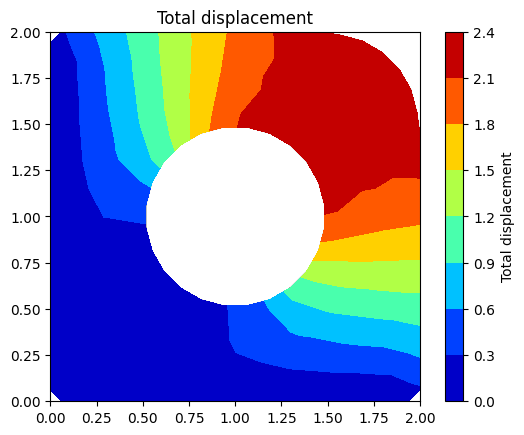

In [39]:
import matplotlib.tri as triang
from matplotlib import cm
# Generate the displacement color map
nodes_all=computed_data['all_nodes']

bound_nodes=computed_data["boundary_nodes"]

u_t=np.sqrt(u[:,0]**2+u[:,1]**2)
uint_t=np.sqrt(uint[:,0]**2+uint[:,1]**2)

title_fig = "Total displacement"
show_results(nodes_all,bound_nodes,int_nodes,nodes,elem,nodes_coord,u_t,uint_t,title_fig)